In [ ]:
!pip install db-sqlite3 lxml selenium

In [ ]:
!apt-get update 
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin


In [ ]:
import sqlite3
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
import time
import pandas as pd
import matplotlib.pyplot as plt

Se crea la  BBDD

In [ ]:
conn = sqlite3.connect('mydatabase.db')
print("Opened database successfully")
cur = conn.cursor()

Se crean las tablas LUGAR y VUELO

In [ ]:
cur.execute("CREATE TABLE IF NOT EXISTS place (descripcion  CHAR(50))")
cur.execute("CREATE TABLE IF NOT EXISTS flight (origen INTEGER, destino INTEGER, compania CHAR(50), escalaida INTEGER, tiempoida REAL, escalavuelta INTEGER, tiempovuelta INTEGER ,price REAL)")

In [4]:
cur.execute("INSERT INTO place(descripcion) VALUES('CORDOBA')")
cur.execute("INSERT INTO place(descripcion) VALUES('MADRID')")
conn.commit()

Se conecta al sitio web despegar. Se buscó los vuelos Córdoba - Madrid

In [6]:

SCROLL_PAUSE_TIME = 0.5


url = 'https://www.despegar.com.ar/shop/flights/results/roundtrip/COR/MAD/2022-12-01/2022-12-15/1/0/0/NA/NA/NA/NA/NA?from=SB&di=1-0'

options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument('--ignore-certificate-errors')
options.add_argument('--incognito')


driver = webdriver.Chrome('chromedriver',options=options)

last_height = driver.execute_script("return document.body.scrollHeight")

# open web page
driver.get(url)
WebDriverWait(driver, 30).until(EC.presence_of_element_located((By.CLASS_NAME, 'COMMON')))
while True:
    # Scroll down to bottom
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

    # Wait to load page
    time.sleep(SCROLL_PAUSE_TIME)

    # Calculate new scroll height and compare with last scroll height
    new_height = driver.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        break
    last_height = new_height
#WebDriverWait(driver, 40).until(EC.presence_of_all_elements_located((By.TAG_NAME,'cluster')))

html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')


In [ ]:
name = soup.find_all('cluster', class_='COMMON')
for link in name:
  print(link.find('span', class_='name').get_text().lstrip())
  print(float(link.find('span', class_='amount price-amount').get_text()))
  way = link.find_all('span', class_='sub-cluster');
  ida = way[0].find('span', class_='stops-wrapper text').get_text() 
  vuelta = way[1].find('span', class_='stops-wrapper text').get_text() 
  print(ida)
  print("Escala ida: ", ida[1])
  print("Tiempo ida ", float(ida[11:13]) + (float(ida[16:18]) / 60))
  print(vuelta)
  print("Escala vuelta: ", vuelta[1])
  print("Tiempo vuelta ",float(vuelta[11:13]) + (float(vuelta[16:18]) / 60))
  

Se realiza insert a la tabla Vuelos

In [15]:
name = soup.find_all('cluster', class_='COMMON')
for link in name:
  compania = link.find('span', class_='name').get_text().lstrip()
  precio = link.find('span', class_='amount price-amount').get_text()
  way = link.find_all('span', class_='sub-cluster');
  ida = way[0].find('span', class_='stops-wrapper text').get_text() 
  vuelta = way[1].find('span', class_='stops-wrapper text').get_text() 
  escala_ida = ida[1]
  tiempo_ida = str(float(ida[11:13]) + (float(ida[16:18]) / 60))
  escala_vuelta = vuelta[1]
  tiempo_vuelta = str(float(vuelta[11:13]) + (float(vuelta[16:18]) / 60))

  cur.execute("INSERT INTO flight VALUES (1, 2, '"+ compania +"',"+ escala_ida +"," + tiempo_ida +"," + escala_vuelta +","+ tiempo_vuelta + "," + precio + ")")
  conn.commit()

In [20]:
vuelos = pd.read_sql("SELECT * FROM flight", conn)

In [ ]:
print(vuelos)

In [ ]:
vuelos.tail()

In [28]:
vuelos[['price']].describe()

,price
count,29.000000
mean,219.738621
std,32.336646
min,148.785000
25%,206.174000
50%,224.976000
75%,238.547000
max,268.958000


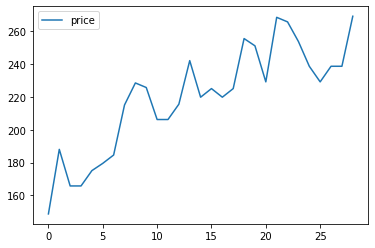

In [30]:
vuelos[['price']].plot()

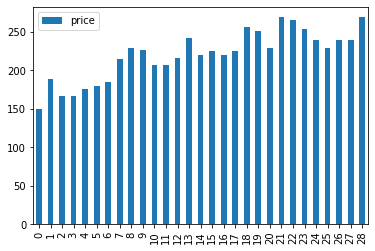

In [31]:
vuelos[['price']].plot(kind='bar')